In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import urllib.parse
from pymongo import MongoClient
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import skew

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
#matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    #x = np.linspace(0, 100, 100)

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

In [3]:
def make_pdf(dist, params, size=1000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [4]:
MONGODB_HOST = pd.read_csv('./database/auth')['host'][0]
username = urllib.parse.quote_plus(pd.read_csv('./database/auth')['username'][0])
password = urllib.parse.quote_plus(pd.read_csv('./database/auth')['password'][0])
conn = MongoClient('mongodb://%s:%s@%s' % (username, password, MONGODB_HOST))

#conn.database_names()

db = conn['KU']
collection_list = db.collection_names()

coll_list = [x for x in collection_list if 'QuizScore' in x]
#score_df = pd.DataFrame(list(db[coll_list[2]].find()))['score'].astype(int)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  if __name__ == '__main__':


In [5]:

bin = 10
arr_pdf = []

for x in range(0, len(coll_list)):
    data = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)

    best_fit_name, best_fit_params = best_fit_distribution(data, bin)
    best_dist = getattr(st, best_fit_name)
    pdf = make_pdf(best_dist, best_fit_params)
    arr_pdf.append(pdf)


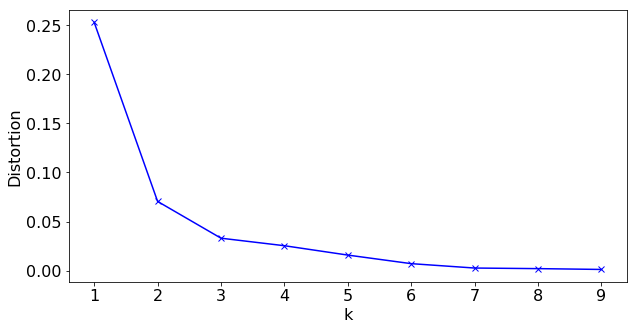

In [11]:
X = np.array(arr_pdf)
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(10, 5))

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'correlation'), axis=1)) / X.shape[0])

lablestring = 'optimal value for k'
#plt.annotate(lablestring, xy=(3, 0.05), xytext=(3, 0.08),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
    
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
#plt.title('The Elbow Method showing the optimal k')
plt.savefig('./images/elbow_lak.png', dpi=300)
plt.show()

In [7]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1], dtype=int32)

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

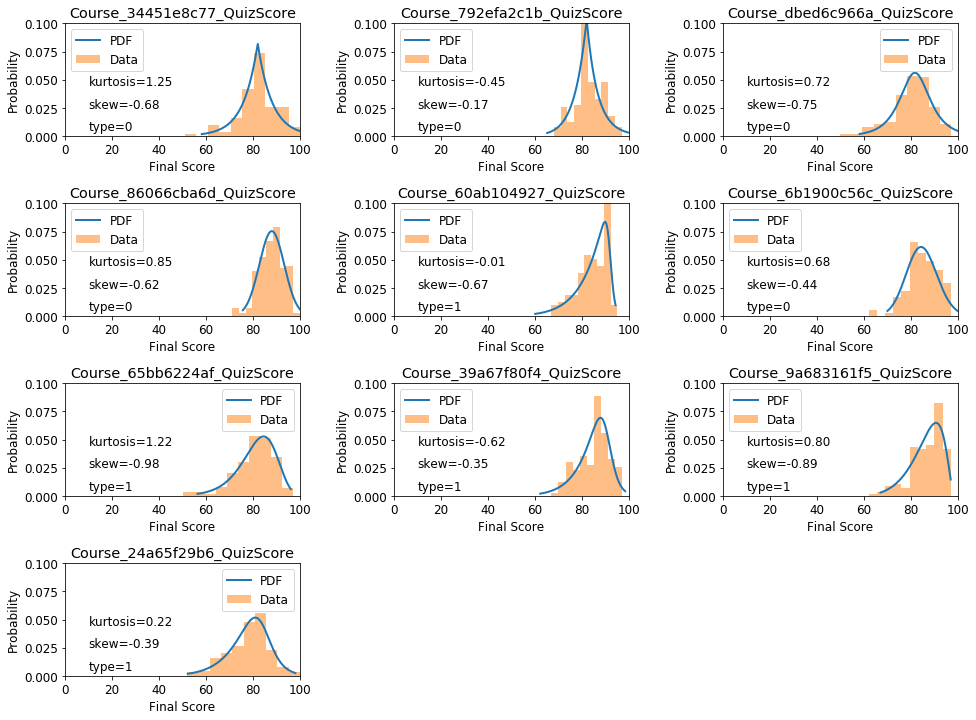

In [8]:
matplotlib.rcParams.update({'font.size': 12})
xmin, xmax = 0, 100
subplot_x = 4
subplot_y = 3
ylimit = 0.1
plt.figure(figsize=(16,12))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
#arr_pdf = []

for x in range(0, len(coll_list)):
    data = pd.DataFrame(list(db[coll_list[x]].find()))['score'].astype(int)

    #best_fit_name, best_fit_params = best_fit_distribution(data, bin)
    #best_dist = getattr(st, best_fit_name)
    #pdf = make_pdf(best_dist, best_fit_params)
    #arr_pdf.append(pdf)

    # Display
    #plt.figure(figsize=(12,8))
    plt.subplot(subplot_x, subplot_y, x+1)
    ax = arr_pdf[x].plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=bin, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    ax.set_title(coll_list[x])
    ax.set_xlabel('Final Score')
    ax.set_ylabel('Probability')
    plt.xlim(xmin, xmax)
    plt.ylim(0, ylimit)
    
    ax.annotate('kurtosis=' + str(format(kurtosis(data), '.2f')), xy=(10, 0.045))
    ax.annotate('skew=' + str(format(skew(data), '.2f')), xy=(10, 0.025))
    ax.annotate('type=' + str(labels[x]), xy=(10, 0.005))
    
    plt.savefig('./images/score_distribution_lak.png', dpi=300)